In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Framingham_Heart_Disease.csv")
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
df.drop(columns = ["education"], inplace = True)

In [4]:
df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [5]:
df.isnull().sum()

male                 0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [6]:
df.fillna(df.median(), inplace = True)
X = df.drop(columns=["TenYearCHD"])
y = df["TenYearCHD"]

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter = 3000, class_weight="balanced"))
])

In [9]:
from sklearn.model_selection import GridSearchCV

params = {"lr__C" : [0.001, 0.01, 0.1, 1, 10, 100]}
classification_regressor = GridSearchCV(model, param_grid = params, scoring = "roc_auc", cv = 5)

In [10]:
classification_regressor.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._iter=3000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'lr__C': [0.001, 0.01, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold and candidat

In [11]:
classification_regressor.best_params_

{'lr__C': 0.01}

In [12]:
classification_regressor.best_score_

np.float64(0.7325149852258338)

In [13]:
best_model = classification_regressor.best_estimator_
y_pred = best_model.predict(X_test)

In [14]:
y_prob = best_model.predict_proba(X_test)[:,1]
y_pred = (y_prob > 0.4).astype(int)

#### When the classes were imbalanced...f1 score for class 1 was 0.12 but after balancing it is 0.35. This shows the importance of balanced dataset

In [15]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
print("Accuracy:-", accuracy_score(y_test, y_pred))
print("f1 score:-",f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:- 0.5495283018867925
f1 score:- 0.34812286689419797
              precision    recall  f1-score   support

           0       0.93      0.51      0.66       719
           1       0.22      0.79      0.35       129

    accuracy                           0.55       848
   macro avg       0.58      0.65      0.50       848
weighted avg       0.82      0.55      0.61       848



In [16]:
# [TP, TN
#  FP, FN]
print(confusion_matrix(y_test, y_pred))

[[364 355]
 [ 27 102]]


#### Scores at different stages
| Stage                    | Recall(1) | Precision(1) | F1(1) |
| ------------------------ | --------- | ------------ | ----- |
| No balancing             | 0.50      | 0.07         | 0.12  |
| Balanced (0.5 threshold) | 0.58      | 0.25         | 0.35  |
| Threshold 0.4            | 0.77      | 0.22         | 0.35  |

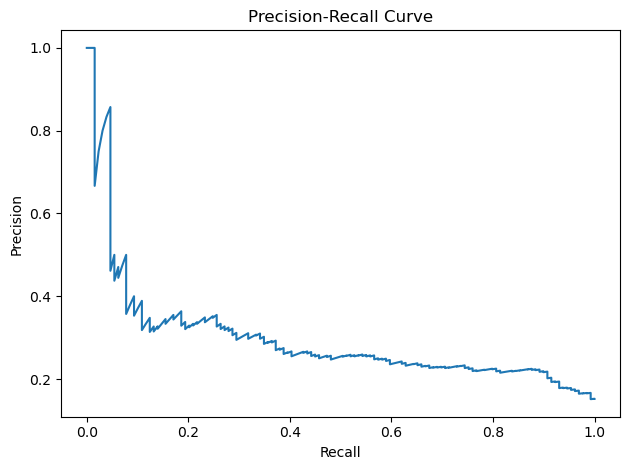

In [17]:
from sklearn.metrics import precision_recall_curve
y_prob = best_model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.tight_layout()

#### What this Precision-Recall Curve tells -
- Logistic regression has limited separation power on this dataset.
- Model struggles separating positives cleanly.
- Many predicted positives are actually false positives.

In [18]:
f1 = "age"
f2 = "sysBP"

x_min, x_max = X[f1].min(), X[f1].max()
y_min, y_max = X[f2].min(), X[f2].max()
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 150),
    np.linspace(y_min, y_max, 150)
)

fixed_values = X.median()
# make fake dataset for prediction
grid_data = []
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        row = fixed_values.copy()
        row[f1] = xx[i, j]
        row[f2] = yy[i, j]
        grid_data.append(row)
grid_df = np.vstack(grid_data)

grid_df = pd.DataFrame(grid_data, columns=X.columns)

Z = best_model.predict_proba(grid_df)[:, 1]
Z = Z.reshape(xx.shape)

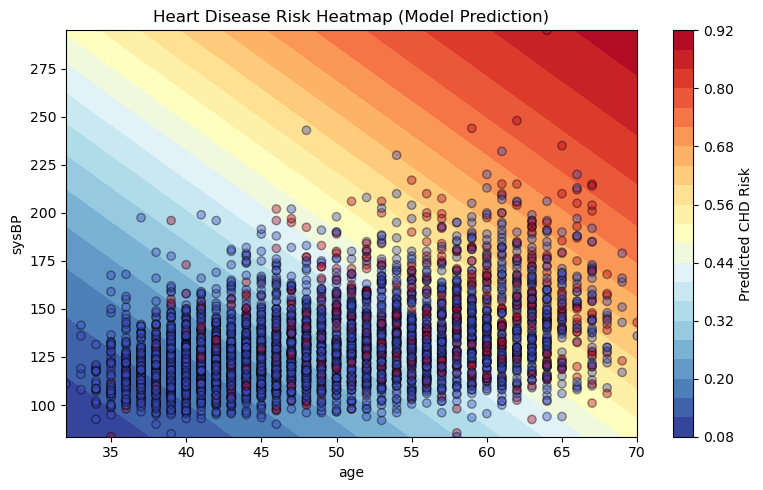

In [19]:
plt.figure(figsize=(8,5))
plt.contourf(xx, yy, Z, levels=25, cmap="RdYlBu_r")
plt.colorbar(label="Predicted CHD Risk")
plt.scatter(
    X[f1],
    X[f2],
    c=y,
    cmap="coolwarm",
    alpha=0.4,
    edgecolor="k"
)
plt.xlabel(f1)
plt.ylabel(f2)
plt.title("Heart Disease Risk Heatmap (Model Prediction)")
plt.tight_layout()

In this study, Logistic Regression was applied to the Framingham Heart Disease dataset to predict the 10-year risk of Coronary Heart Disease (CHD) using demographic, behavioral, and medical risk factors. After preprocessing, handling missing values, scaling features, and addressing class imbalance, the model was evaluated using appropriate metrics such as precision, recall, and F1-score instead of relying solely on accuracy.


The risk heatmap visualization provides an interpretable representation of the model’s predictions. The plot shows a smooth gradient of predicted CHD probability across age and systolic blood pressure while keeping other features constant. The results indicate that:

- CHD risk increases progressively with higher age and higher systolic blood pressure, confirming known medical relationships.
- Younger individuals with lower blood pressure fall in low-risk regions, while older individuals with elevated blood pressure lie in high-risk regions.
- The gradual color transition demonstrates that logistic regression models disease risk probabilistically rather than producing abrupt class boundaries.
- Overlapping data points across risk regions indicate that the dataset is not perfectly separable, explaining why model performance reaches a practical limit despite tuning.


Lowering the decision threshold improved sensitivity (recall) for detecting heart disease cases, which is important in medical screening where false negatives are more dangerous than false positives.


Overall, the model successfully captures meaningful clinical trends and provides an interpretable risk estimation framework. While logistic regression offers transparency and medical interpretability, the overlapping class distributions suggest that further performance improvements may require more complex nonlinear models or additional predictive features.